# Predicting stock closing price from stock data using the Hidden Markov Model to identify latent states

## Hidden Markov Model

A Hidden Markov Model, or HMM for short, may be thought of as a double stochastic process:
1. A hidden or latent Markov stochastic process
2. An observable stochastic process that produces sequences of observations

Since HMMs are often used to capture long-term sequences and hence time-based phenomena, they may prove to be useful in analysis of financial markets.

## Goal

We are going to take the features of opening price, low price, high price and use these to derive some fractional changes. With these fractional changes, we will observe sequences (observations) from which we will derive latent factors in a Markov process. These latent factors will often vary from company to company, which is why it's often hard to fit one linear model of a certain subset of variables for all companies. Once the latent factors and their transitions and starting probabilities (the hidden sequence) are found, we will try to generate some possible values for each of the features and then check how they score with a sequence of test data. The set of possible values that leads to the highest score is then used to predict the closing price for that day.

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import yfinance as yf
import datetime
import time
import requests
import io

In [3]:
data = pd.read_csv("C:/Users/DELL/Downloads/AXISBANK.NS (1) (1).csv")

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-01,755.000000,760.000000,740.000000,752.349976,752.349976,11694854
1,2021-11-02,752.500000,761.349976,748.049988,755.849976,755.849976,11812106
2,2021-11-03,759.450012,762.650024,748.500000,750.599976,750.599976,10529505
3,2021-11-04,757.000000,757.049988,751.400024,752.950012,752.950012,793433
4,2021-11-08,761.000000,761.000000,741.500000,751.049988,751.049988,13872770


In [5]:
data.shape

(110, 7)

## Preprocessing
For the Axis Bank data we have 110 instances of daily open, close , high and low prices for the stock.
we have used 88 days for training our model and we have predicted the values for the next 15 days


### Train-test split

For all data, we are going to do a 80-20 train-test split.

In [6]:
train_size = int(0.8*data.shape[0])
print(train_size)

88


In [7]:
train_data = data.iloc[0:train_size]
test_data = data.iloc[train_size+1:]

In [8]:
test_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
89,2022-03-10,707.900024,720.400024,688.250000,694.950012,694.950012,23224756
90,2022-03-11,691.900024,706.650024,687.450012,690.849976,690.849976,14224356
91,2022-03-14,694.700012,712.400024,685.000000,710.049988,710.049988,10720884
92,2022-03-15,713.000000,718.000000,695.000000,698.150024,698.150024,12157425
93,2022-03-16,711.000000,726.000000,709.099976,723.849976,723.849976,10038170


### Extracting features



We are going to be working with 3 features:
1. The fractional change in opening and closing prices (fracocp)
2. The fractional change in high prices (frachp)
3. The fractional change in low prices (fraclp)

These will be obtained individually in the train and test datasets.

In [9]:
def augment_features(dataframe):
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)
    
    return new_dataframe

In [10]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

## Hidden Markov Models with hmmlearn

### Model

We are first going to import the GaussianHMM from hmmlearn.hmm and then fit it with 3 hidden components (or states) to our training data. We start off with 3 hidden states, but it may be possible to do a grid search among a possible set of values for the number of hidden states to see which works the best.
We are taking just 3 states for the sake of simplicity.

In [11]:
!pip install hmmlearn

In [12]:
from hmmlearn.hmm import GaussianHMM

In [13]:
model = GaussianHMM(n_components = 3,n_iter=20)

In [14]:
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)
model.fit(features_train)

GaussianHMM(n_components=3, n_iter=20)

In [15]:
model.transmat_ #transition matrix

array([[2.89747103e-01, 7.10252897e-01, 4.29053325e-21],
       [1.04523978e-02, 9.89547602e-01, 1.88955821e-21],
       [8.22095965e-01, 1.77904035e-01, 4.88293274e-20]])

In [16]:
model.startprob_ #initial prob matrix

array([7.91823322e-07, 9.99999208e-01, 1.88937849e-29])

In [17]:
model.monitor_

ConvergenceMonitor(
    history=[618.9717871831004, 723.3370400014337, 726.4465351117288, 734.0781118854984, 745.2394262313215, 756.7209888924909, 767.5852418821898, 771.9039442940747, 770.843547731002],
    iter=9,
    n_iter=20,
    tol=0.01,
    verbose=False,
)

In [18]:
model.means_

array([[ 0.04619233,  0.05150062,  0.00891427],
       [-0.00203903,  0.01101917,  0.01410778],
       [ 0.04957833,  0.05457437,  0.00904918]])

In [19]:
model.covars_

array([[[8.19023890e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.04476293e-03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.97931685e-03]],

       [[3.26934812e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.16663053e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.31789396e-04]],

       [[1.00000000e+03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.00000000e+03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+03]]])

### Generating possible sequences

To generate possible possible permutations of values for the features we take the Cartesian product across a range of values for each feature as seen below. We assume a few things here to reduce model complexity.
1. We assume that the distribution of each features is across an evenely spaced interval instead of being fully continuous
2. We assume possible values for the start and end of the intervals

In [20]:
import itertools

test_augmented = augment_features(test_data)
fracocp = test_augmented['delOpenClose']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 50)
sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), 10)
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), 10)

possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

### Checking predictions

We use the data of the last 10 (latent) days to predict the closing price of the current day, and we repeat those for 15 days (this value does not matter at all)

In [21]:
num_latent_days = 10
num_days_to_predict = 15

Here we are using the MAP (maximum a posteriori) estimate in the discrete set obtained above given the model parameter as the predicted value of the next observation as the stock is very likely to follow the trend that it has followed in the past.

For each of the days that we are going to predict closing prices for, we are going to take the test data for the previous num_latent_days and try each of the outcomes in possible_outcomes to see which sequence generates the highest score. The outcome that generates the highest score is then used to make the predictions for that day's closing price.

In [22]:
from tqdm import tqdm

predicted_close_prices = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))
    
    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data)) #loglikelihood
        
    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:21<00:00,  1.44s/it]


In [23]:
most_probable_outcome

array([-0.00206302,  0.01104613,  0.01472818])

In [24]:
total_data

array([[ 0.0180731 ,  0.02109705,  0.00267233],
       [ 0.00305292,  0.01322931,  0.00074625],
       [-0.02563755,  0.00590607,  0.02859059],
       [ 0.00329221,  0.00960219,  0.03106999],
       [-0.01270205,  0.00923794,  0.01555489],
       [ 0.00438051,  0.01578367,  0.00013903],
       [-0.00283422,  0.0046316 ,  0.01078389],
       [ 0.0137741 ,  0.01639122,  0.01508266],
       [-0.00519118,  0.        ,  0.01435991],
       [ 0.00461849,  0.02523424,  0.00763054],
       [ 0.02936969,  0.0331384 ,  0.0331384 ]])

Plotting the predicted closing prices and the actual closing prices, we see the following

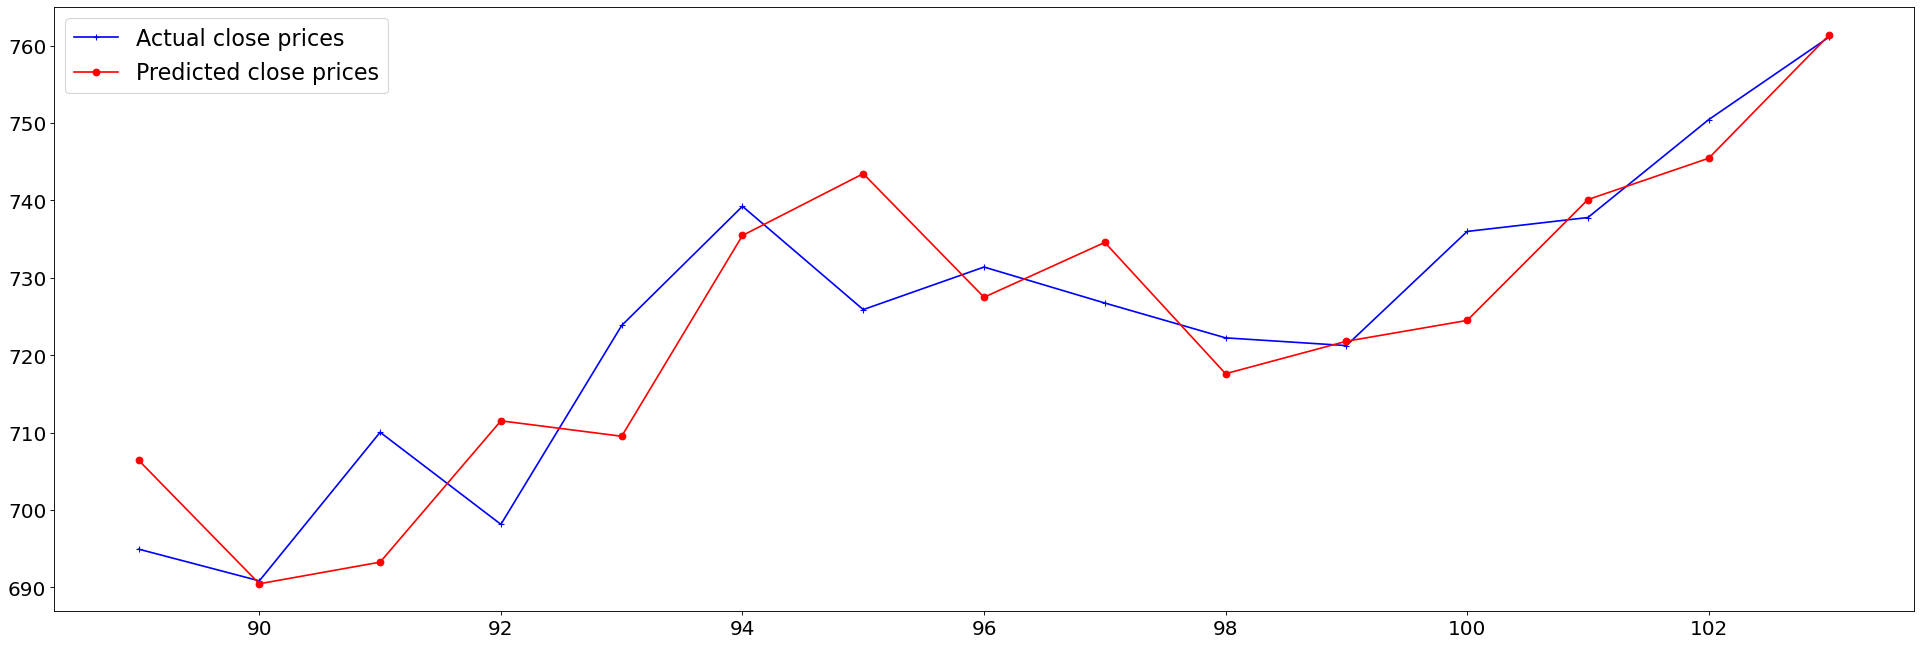

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_data.index[0:num_days_to_predict])
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predicted_close_prices, 'ro-', label="Predicted close prices")
plt.legend(prop={'size': 20})
plt.show()

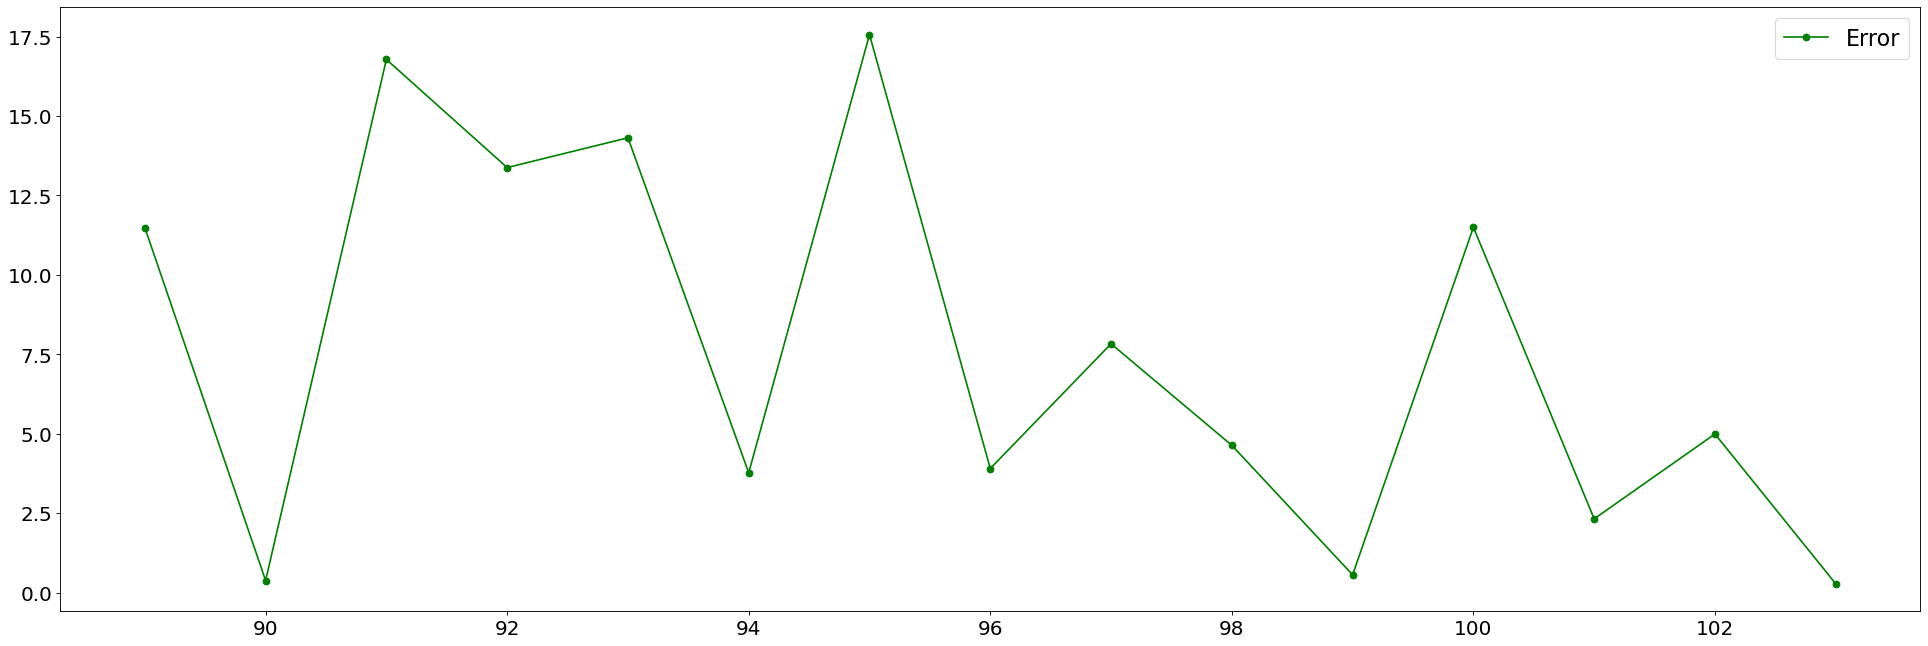

In [26]:
ae = abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)

plt.figure(figsize=(30,10), dpi=80)

plt.plot(x_axis, ae, 'go-', label="Error")
plt.legend(prop={'size': 20})
plt.show()

In [27]:
print("Max error observed = " + str(ae.max()))
print("Min error observed = " + str(ae.min()))
print("Mean error observed = " + str(ae.mean()))

Max error observed = 17.563026261208506
Min error observed = 0.2758919051035491
Mean error observed = 7.579389241973028
